<a href="https://colab.research.google.com/github/IFuentesSR/FES_drought/blob/main/z_scores_for_SVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Continuous NDVI collection from AVHRR and MODIS

In [2]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=e1SohWU5J3G8XDxG1syhUWcjJNzIDZ8cku_UtJ7oNL4&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWj9zcvD3G9v8ir-ActzYEE2AEKf-D-tWPESS-MmgXheafnSS4PKJeQ

Successfully saved authorization token.


In [13]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
## needs AVHRR - MODIS collection (AllGiAggs)
AllGiAggs = ee.ImageCollection(AllGiAggs)

## Mapping a single date from collection

In [6]:
sviId = AllGiAggs.filterDate('2005-04-01', '2012-01-01').first().getMapId({})
map = folium.Map(location=[-30.63, 149.91], zoom_start=2)
folium.TileLayer(
    tiles=sviId['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='svi_april2005',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

### Defining functions to work with collection

In [11]:
def set_month(img):
    return img.set('month', ee.Date(img.get('system:time_start')).get('month'))


def aggregation(collection, scale):
    def inner(date):
        date0 = ee.Date(date)
        img = ee.Image(collection.filter(ee.Filter.eq('system:time_start', date)).first())
        props = img.propertyNames()
        condition = ee.Algorithms.If(ee.Number(ee.ImageCollection(collection.filterDate(date0.advance(ee.Number(scale).multiply(-1), 'month'), date0)).size()).lt(scale),
                                     ee.Image().set('drop',1),
                                     ee.Image(collection.filterDate(date0.advance(ee.Number(scale).multiply(-1), 'month'), date0).mean()).set('drop',0))
        return ee.Image(condition).copyProperties(img, props).set('month', date0.get('month'))
    return inner


def z_scores(collection):
    def wrap(i):
        img = ee.Image(i)
        props = img.propertyNames()
        coll = collection.filter(ee.Filter.eq('month', i.get('month')))
        mean = ee.ImageCollection(coll).mean()
        sdv = ee.ImageCollection(coll).reduce(ee.Reducer.stdDev())
        return img.subtract(mean).divide(sdv).copyProperties(img, props)
    return wrap


def get_sample(geometry):
    def wrap(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        svi_value = img.reduceRegion('first', geometry, 5000).values().get(0)
        return ee.Feature(None, {'date':date, 'svi':svi_value})
    return wrap

## Creating SVI series

In [8]:
AllGiAggs = AllGiAggs.map(set_month)
dates = AllGiAggs.aggregate_array('system:time_start')
GiAggs2 = dates.map(aggregation(AllGiAggs, 3))
GiAggs2 = GiAggs2.filter(ee.Filter.eq('drop', 0))
GiAggs2 = ee.ImageCollection.fromImages(GiAggs2).filterDate('1981-10-01', '2021-01-01')
svi = GiAggs2.map(z_scores(GiAggs2))

## Mapping SVI for single date 

In [9]:
sviId = svi.filterDate('2005-04-01', '2012-01-01').first().getMapId({'min': -3, 'max': 3, 'palette':'FF0000, FFFFFF, 0000FF'})
map = folium.Map(location=[-30.63, 149.91], zoom_start=2)
folium.TileLayer(
    tiles=sviId['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='svi_april2005',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [ ]:
geo = ee.Geometry.Point([149.5462, -30.2282])
series = svi.map(get_sample(geo)).getInfo()

ixs = [n['properties']['svi'] for n in series['features']]
time = [pd.to_datetime(n['properties']['date'], format='%Y-%m-%d') for n in series['features']]
df = pd.DataFrame(data={'svi':ixs, 'date':time})
d = np.zeros(len(ixs))

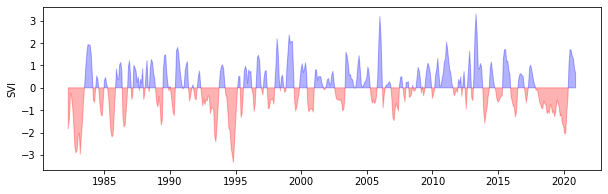

In [16]:
fig, axs = plt.subplots(figsize=(10, 3))
axs.fill_between(time, d, ixs, where=df['svi']>=d, interpolate=True, color='blue', alpha=0.3, label='SVI')
axs.fill_between(time, d, ixs, where=df['svi']<=d, interpolate=True, color='red', alpha=0.3)
axs.set_ylabel('SVI')
fig.show()